# Data exploration of experimental events
* https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array
## Data import

In [140]:
# Imports
import matplotlib.pyplot as plt
from master_scripts.data_functions import *
from pprint import pprint
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events
REPO_ROOT = get_git_root()
DATA_PATH = REPO_ROOT + "/data/real/anodedata_500k.txt"
DATA_FILENAME = "anodedata_500k.txt"

events, images = import_real_data(DATA_PATH) # images not normalized

In [142]:
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events
# ================== Import Data ==================
#images = np.load(DATA_PATH + "images_full.npy")
#positions = np.load(DATA_PATH + "positions_full.npy")
#energies = np.load(DATA_PATH + "energies_full.npy")
#labels = np.load(DATA_PATH + "labels_full.npy")
images_sim = np.load(REPO_ROOT + "data/simulated/images_260k.npy")
positions_sim = np.load(REPO_ROOT + "data/simulated/positions_260k.npy")
energies_sim = np.load(REPO_ROOT + "data/simulated/energies_260k.npy")
labels_sim = np.load(REPO_ROOT + "data/simulated/labels_260k.npy")
single_sim, double_sim, close_sim = event_indices(positions_sim)
print(f"S: {single_sim.shape}, D: {double_sim.shape}, C: {close_sim.shape}")

S: (130279,), D: (129868,), C: (1809,)


# Basic statistical properties
Means, standard deviations etc.

## Images
num_observations, (min, max), mean, variance, skewness, kurtosis

In [143]:
decays = [e['image_idx'] for e in events.values() if e['event_descriptor'] == 2]

In [144]:
print(len(decays))

260147


In [145]:
stats_images = stats.describe(images[decays])

In [146]:
# Print maximum and minimum pixel values seen in image data
print("{:15s}|{:^15s}|{:^15s}|{:^15s}|{:^15s}".format(
    "Image set",
    "pixel min",
    "pixel max",
    "pixel mean",
    "pixel STD (mean)"))
print("{:15s}|{:^15.2f}|{:^15.2f}|{:^15.2f}|{:^15.2f}".format(
    "All images", 
    np.amin(stats_images.minmax[0]),
    np.amax(stats_images.minmax[1]),
    np.mean(stats_images.mean),
    np.mean(np.sqrt(stats_images.variance))))

Image set      |   pixel min   |   pixel max   |  pixel mean   |pixel STD (mean)
All images     |     0.00      |    8530.83    |    226.38     |    337.86     


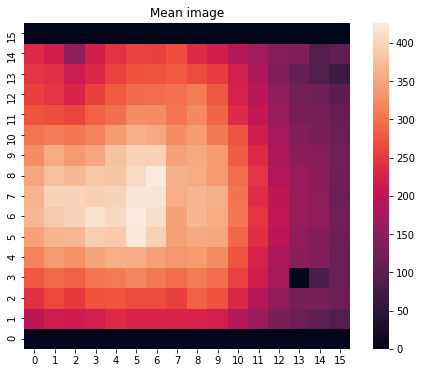

In [147]:
# Plot the mean image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(stats_images[2].reshape((16,16)), ax=ax, square=True)
ax.set_title("Mean image")
ax.invert_yaxis()

## Highest intensity pixel heatmap
Extract the positions of highest intensity pixels across the dataset and plot the
resulting heatmap

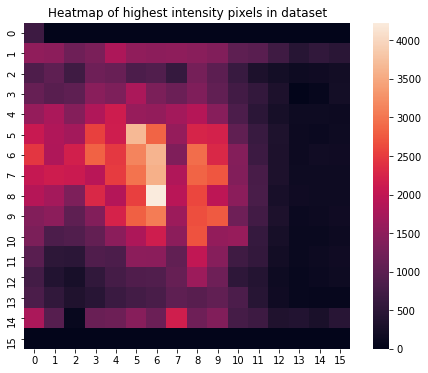

In [148]:
# Reshape input array to a 2D array with rows being kept as with original array.
# Then, get idnices of max values along the columns.
pix_hmap = np.zeros(images[0].shape)
max_idx = images.reshape(images.shape[0],-1).argmax(1)
# Get unravel indices corresponding to original shape of A
maxpos_vect = np.column_stack(np.unravel_index(max_idx, images[0,:,:].shape))
np.add.at(
    pix_hmap, 
    (
        maxpos_vect[decays, 0],
        maxpos_vect[decays, 1],
        maxpos_vect[decays, 2]
    ),
    1
)
#pix_hmap[maxpos_vect[:, 0], maxpos_vect[:, 1], maxpos_vect[:, 2]] += 1
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Heatmap of highest intensity pixels in dataset')
sns.heatmap(pix_hmap.reshape((16,16)), ax=ax, square=True)


## Where do "dead" pixels occur
Extract the positions of "dead" pixels across the dataset and plot the
resulting heatmap, annotated with ratio of images where the pixel is zero

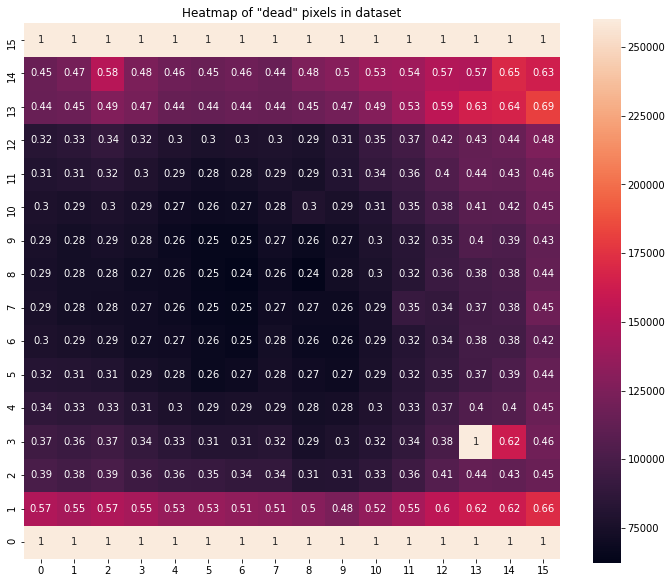

In [149]:
zeros_hmap = np.zeros(images[decays].shape)
np.add.at(zeros_hmap, np.where(images[decays] == 0), 1)
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Heatmap of "dead" pixels in dataset')
zeros_hmap = zeros_hmap.sum(axis=0)
ratios = (zeros_hmap/images[decays].shape[0]).reshape(16, 16)
sns.heatmap(zeros_hmap.reshape(16, 16), square=True, ax=ax, annot=ratios)
ax.invert_yaxis()

# Distribution comparisons between sim and exp
Though we lack true values for energies, positions, and labels for experimental data, 

In [150]:
images = normalize_image_data(images[decays])
images_sim = normalize_image_data(images_sim)

In [151]:
img_sum = np.sum(images, axis=(1,2))
img_hip = np.amax(images, axis=(1,2))
img_sum_sim = np.sum(images_sim, axis=(1,2))
img_hip_sim = np.amax(images_sim, axis=(1,2))

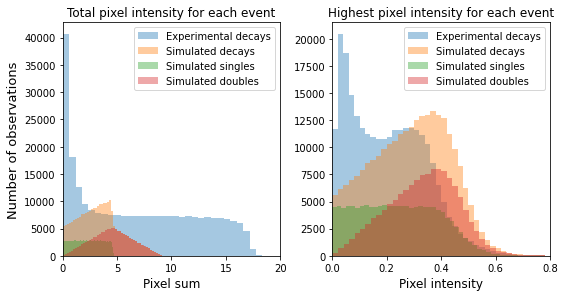

In [152]:

fig, ax = plt.subplots(1, 2, figsize=(8,4))

# Sum all
sns.distplot(img_sum, kde=False, label='Experimental decays', ax=ax.flatten()[0])
sns.distplot(img_sum_sim, kde=False, label='Simulated decays', ax=ax.flatten()[0])
ax.flatten()[0].set_ylabel("Number of observations", fontsize=13)
#ax.flatten()[0].set_xlabel("Pixel sum", fontsize=12)
ax.flatten()[0].set_title("Total pixel intensity for each event")
ax.flatten()[0].legend()

# HIP all
sns.distplot(img_hip, kde=False, label='Experimental decays', ax=ax.flatten()[1])
sns.distplot(img_hip_sim, kde=False, label='Simulated decays', ax=ax.flatten()[1])
ax.flatten()[1].set_title("Highest pixel intensity for each event")
ax.flatten()[1].legend()
fig.tight_layout()


#fig1, ax1 = plt.subplots(1, 2, figsize=(8,5), sharey=True)
# Sum single/double
sns.distplot(img_sum_sim[single_sim], kde=False, label='Simulated singles', ax=ax.flatten()[0])
sns.distplot(img_sum_sim[double_sim], kde=False, label='Simulated doubles', ax=ax.flatten()[0])
#x.flatten()[0].set_ylabel("Number of observations", fontsize=13)
ax.flatten()[0].set_xlabel("Pixel sum", fontsize=12)
ax.flatten()[0].legend()


# HIP single/double
sns.distplot(img_hip_sim[single_sim], kde=False, label='Simulated singles', ax=ax.flatten()[1])
sns.distplot(img_hip_sim[double_sim], kde=False, label='Simulated doubles', ax=ax.flatten()[1])
ax.flatten()[1].set_xlabel("Pixel intensity", fontsize=12)
ax.flatten()[1].legend()

ax.flatten()[0].set_xlim(0, 20)
#ax.flatten()[0].ticklabel_format(axis='x', scilimits=(3,3))
ax.flatten()[1].set_xlim(0, 0.8)
#ax.flatten()[1].ticklabel_format(axis='x', scilimits=(3,3))

fig1.tight_layout()

In [155]:
img_hip = img_hip.reshape(img_hip.shape[0])
img_sum = img_sum.reshape(img_sum.shape[0])

img_hip_sim = img_hip_sim.reshape(img_hip_sim.shape[0])
img_sum_sim = img_sum_sim.reshape(img_sum_sim.shape[0])

Sim: 11.693386007924477x + -0.5177085664237217
Exp: 36.049322173939224x + -0.5177085664237217


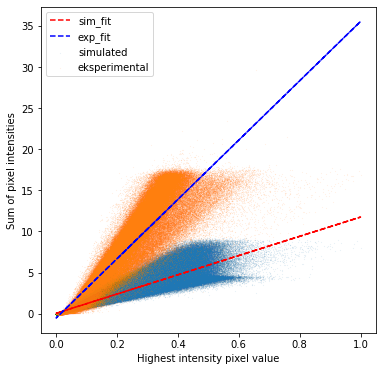

In [159]:
fig, ax = plt.subplots(figsize=(6,6))
a_sim, b_sim = np.polyfit(img_hip_sim, img_sum_sim, 1)
a_exp, b_exp = np.polyfit(img_hip, img_sum, 1)

ax.scatter(img_hip_sim, img_sum_sim, label='simulated', s=0.001,)
ax.plot(img_hip_sim, a_sim*img_hip_sim + b_sim, '--r', label='sim_fit')
ax.scatter(img_hip, img_sum, label='eksperimental', s=0.001)
ax.plot(img_hip, a_exp*img_hip + b_exp, '--b', label='exp_fit')
ax.set_xlabel("Highest intensity pixel value")
ax.set_ylabel("Sum of pixel intensities")
ax.legend()

print(f"Sim: {a_sim}x + {b_exp}")
print(f"Exp: {a_exp}x + {b_exp}")


In [ ]:
custom_ex_id = "424cc250c5ab"
#custom_ex = load_experiment(custom_ex_id)
custom_model = tf.keras.models.load_model(REPO_ROOT + "models/" + custom_ex_id + ".h5", compile=False)
#custom_test = classification_metrics(custom_model, images, events, "custom_test")
predictions = custom_model.predict(images)
#del custom_model

In [ ]:
single = (predictions <= 0.5)
double = (predictions > 0.5)
n_single = np.sum(single.astype(int))
n_double = np.sum(double.astype(int))
n_tot = n_single + n_double
print(f"S: {n_single}, {n_single/n_tot} | D: {n_double}, {n_double/n_tot} |")

img_sum = np.sum(images, axis=(1,2))
img_hip = np.amax(images, axis=(1,2))
fig, ax = plt.subplots(1, 2, figsize=(8,4))

# Sum single/double
sns.distplot(img_sum[single], kde=False, label='single', ax=ax.flatten()[0])
sns.distplot(img_sum[double], kde=False, label='double', ax=ax.flatten()[0])
ax.flatten()[0].set_ylabel("Number of observations", fontsize=12)
ax.flatten()[0].set_xlabel("Pixel sum", fontsize=12)
ax.flatten()[0].legend()
ax.flatten()[0].set_xlim(0, 20)

sns.distplot(img_sum[single], kde=False, label='single', ax=ax.flatten()[1])
sns.distplot(img_sum[double], kde=False, label='double', ax=ax.flatten()[1])
#ax.flatten()[1].set_ylabel("Number of observations", fontsize=12)
ax.flatten()[1].set_xlabel("Pixel sum", fontsize=12)
ax.flatten()[1].legend()
ax.flatten()[1].set_xlim(0, 5)

# HIP single/double
#sns.distplot(img_hip[single], kde=False, label='single', ax=ax.flatten()[1])
#sns.distplot(img_hip[double], kde=False, label='double', ax=ax.flatten()[1])
#ax.flatten()[1].set_xlabel("Pixel intensity", fontsize=12)
#ax.flatten()[1].legend()
#ax.flatten()[1].set_xlim(0, 0.8)

fig.tight_layout()

## Test with scaled single events
Can partially explain problems with double predictions on experimental?

In [ ]:
a_factors = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
predicted_singles = []
for a in a_factors:
    pred = custom_model.predict((images_sim[single_sim]*a).reshape(single_sim.shape[0], 16, 16, 1))
    pred_s = np.sum((pred <= 0.5).astype(int))
    predicted_singles.append(pred_s/single_sim.shape[0])
plt.scatter(a_factors, predicted_singles)
plt.xlabel("Scaling factor")
plt.ylabel("Fraction of correct singles.")

In [ ]:
print(predicted_singles)

In [ ]:
fig2, ax2 = plt.subplots(figsize=(8,4))
sns.distplot(img_sum, kde=False, label='single', ax=ax2)
for a in a_factors[:4]:
    # Sum single/double
    sns.distplot(img_sum_sim[single_sim]*a, kde=False, label='single', ax=ax2)
    #sns.distplot(imsum, kde=False, label='double', ax=ax.flatten()[0])
    ax2.set_ylabel("Number of observations", fontsize=12)
    ax2.set_xlabel("Pixel sum", fontsize=12)
    ax2.legend()